In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Markdown, display
from perceptron import Perceptron, Perceptron_ada, Perceptron_multi
from report import model_report, compare_models
from sklearn.model_selection import train_test_split

In [2]:
sns.set_theme()

### Имеется датасет с данными о 333 пингвинах. По каждому пингвину известно: 
- species - информация о виде пингвина;
- island - название острова в архипелаге Палмера;
- bill_length_mm - длина клюва в мм;
- bill_depth_mm - толщина клюва в мм;
- flipper_length_mm - длина крыла в мм;
- body_mass_g - масса тела в граммах;
- sex - пол особи.


Необходимо на основе этих данных построить ряд классификаторов и проверить их работу.


# Задание 1 (в классе). Предварительное исследование данных

### 1. Загрузить данные из файла «pinguins.csv». Проверить, что загружены все 333 кортежа данных по всем 7 признакам


In [3]:
df = pd.read_csv("penguins.csv")
df.sample(5)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
2,Adelie,Torgersen,40.3,18.0,195,3250,female
219,Gentoo,Biscoe,48.6,16.0,230,5800,male
25,Adelie,Dream,39.5,16.7,178,3250,female
172,Gentoo,Biscoe,47.8,15.0,215,5650,male
265,Chinstrap,Dream,46.5,17.9,192,3500,female


### 2. Определить типы данных

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            333 non-null    object 
 1   island             333 non-null    object 
 2   bill_length_mm     333 non-null    float64
 3   bill_depth_mm      333 non-null    float64
 4   flipper_length_mm  333 non-null    int64  
 5   body_mass_g        333 non-null    int64  
 6   sex                333 non-null    object 
dtypes: float64(2), int64(2), object(3)
memory usage: 18.3+ KB


### 3. Определить параметры числовых данных


In [5]:
df.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,333.000000,333.000000,333.000000,333.000000
mean,43.992793,17.164865,200.966967,4207.057057
std,5.468668,1.969235,14.015765,805.215802
min,32.100000,13.100000,172.000000,2700.000000
25%,39.500000,15.600000,190.000000,3550.000000
50%,44.500000,17.300000,197.000000,4050.000000
75%,48.600000,18.700000,213.000000,4775.000000
max,59.600000,21.500000,231.000000,6300.000000


### 4. Для нечисловых (текстовых) данных определить количество записей по каждому элементу и визуализировать гистограммы, например, так (для признака «species»)

In [6]:
categorical = df.select_dtypes(include=['object']).columns

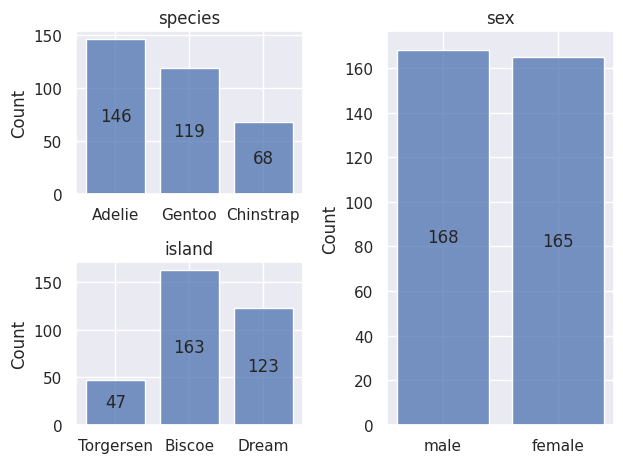

In [7]:
parts = [(2, 2, 1), (2, 2, 3), (1, 2, 2)]
for p, col in zip(parts, categorical):
    ax = plt.subplot(*p)
    sns.histplot(
        data=df,
        x=col,
        ax=ax,
        shrink=0.8,
    )
    for i in ax.containers:
        ax.bar_label(
            container=i,
            label_type="center",
        )
    ax.set_xlabel("")
    ax.set_title(col)
plt.tight_layout()

### 5. Для каждого текстового признака построить мозаику 2D диаграмм рассеяния выбирая в качестве параметров всевозможные пары числовых признаков, аналогично мозаике диаграмм для ирисов.


На основе полученных результатов сделать предварительную оценку качества классификации пингвинов по каждому из трёх текстовых признаков на основе только числовых признаков. 

In [8]:
# for col in categorical:
#     sns.pairplot(df, hue=col, diag_kind="hist")

Признаки линейно неразделимы, за исключением вида Gentoo признака species, который линейно разделим с другими видами.

## Стандартизация

Числовые признаки имеют величины разного масштаба, проведем стандартизацию

In [9]:
numeric = list(df.select_dtypes(exclude=['object']).columns)
args = df[numeric].agg(("mean", "std"))
scaled = df.copy()
scaled[numeric] -= args.loc["mean"]
scaled[numeric] /= args.loc["std"]

# Задание 2. Бинарная классификация персептроном

        Замечание 1: Все классификаторы оформить в виде объектов некоторого написанного вами класса с обязательными конструктором, методами fit() и predict().
        Замечание 2: Для оценку качества работы классификатора использовать метрику качества Accuracy (точность) – доля объектов тестовой выборки, класс которых был распознан правильно.
        Замечание 3: оценку качества работы классификатора выполнять в 2-х вариантах. Сначала используя всю выборку как обучающую и как тестовую (одна оценка accuracy), а потом с разделением исходной выборки на 2 части: 70% - обучающая выборка (по ней будет обучаться классификатор) и 30% - тестовая выборка (объекты этой группы не будут использованы для обучения классификатора). Точность классификации показывать на обеих выборках – обучающей и тестовой. Объяснять различие полученных значений.



### 1. Используя персептрон, постройте бинарный классификатор для определения пола пингвина на основе только числовых признаков. Оцените качество работы классификатора.



In [10]:
train, test = train_test_split(df.index,
                               test_size=0.3,
                               random_state=42)

### Кусочек обучающей выборки:

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
120,-0.949553,0.220967,-0.711125,-1.157525,female
166,1.135049,-1.454811,1.215277,1.854090,male
32,-0.327830,0.677997,-1.495956,-0.816001,female
327,0.312180,-0.083720,-0.425733,-0.691811,female
173,0.769329,-1.454811,0.644491,0.487997,female


### Параметры обучения:

,epoch,eta
,20,0.1


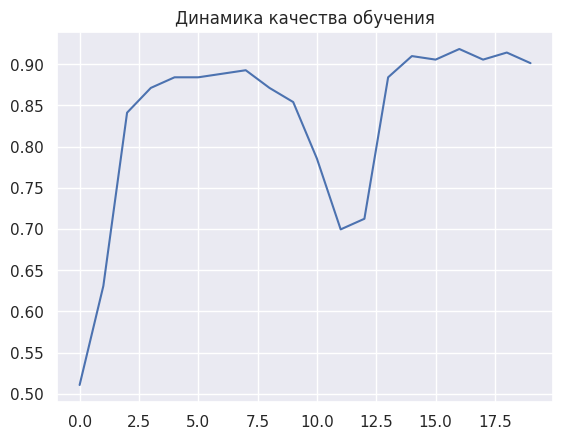

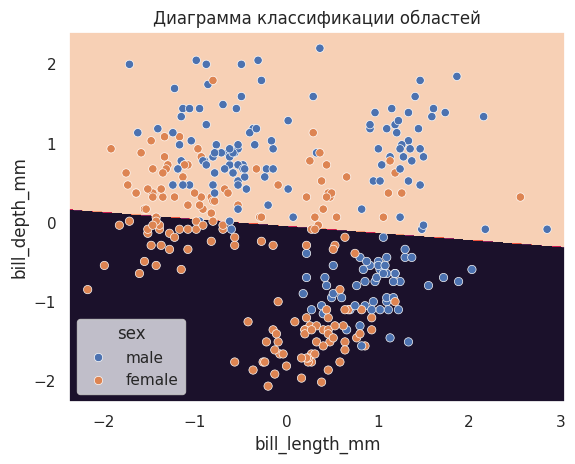

### Оценка качетсва:

Accuracy: 88.00%

In [11]:
model_num = model_report(
    model=Perceptron,
    dataset=scaled,
    X=numeric,
    y="sex",
    train=train,
    train_args=dict(
        epoch=20,
        eta=1e-1
    )
)

### 2. Постройте 3 классификатора для определения пола пингвина на основе числовых признаков для каждого из видов пингвинов. Оцените их качество. Сравните точности классификаторов между собой и с классификатором п.2.1.



# Adelie

### Кусочек обучающей выборки:

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
136,-2.174715,-0.845437,-0.925170,-1.436953,female
65,-0.784980,0.627216,-0.782474,-0.381335,male
28,-0.565548,0.881121,-1.210563,-0.381335,male
34,-0.766694,0.982683,-1.210563,0.550092,male
12,-0.272972,1.795182,-0.283036,0.363807,male


### Параметры обучения:

,epoch,eta
,20,0.1


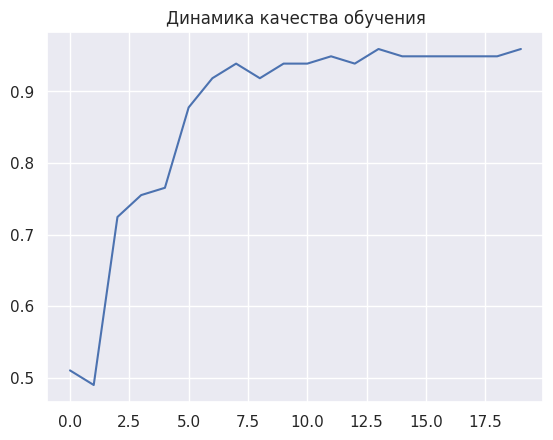

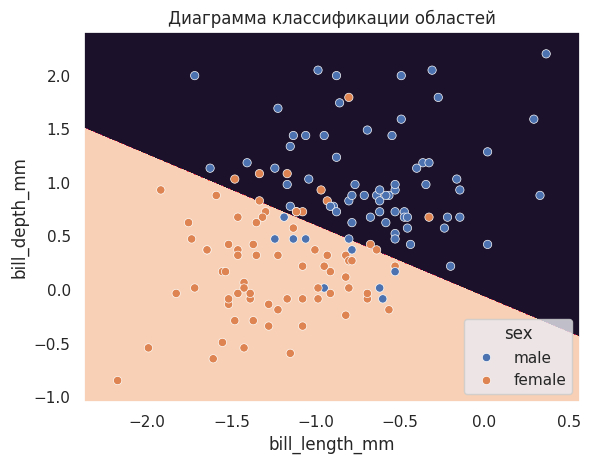

### Оценка качетсва:

Accuracy: 85.42%

# Gentoo

### Кусочек обучающей выборки:

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
200,0.184178,-0.896218,1.357973,1.046853,male
223,0.220750,-0.388407,1.572018,2.164566,male
153,0.495040,-0.946999,1.286625,1.233139,male
219,0.842473,-0.591532,2.071455,1.978281,male
214,0.677899,-1.099343,1.072580,0.674283,female


### Параметры обучения:

,epoch,eta
,20,0.1


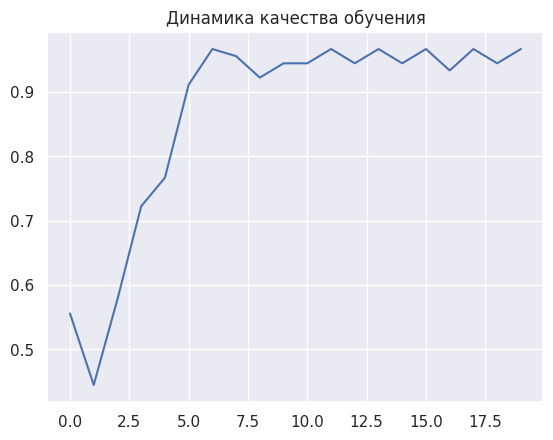

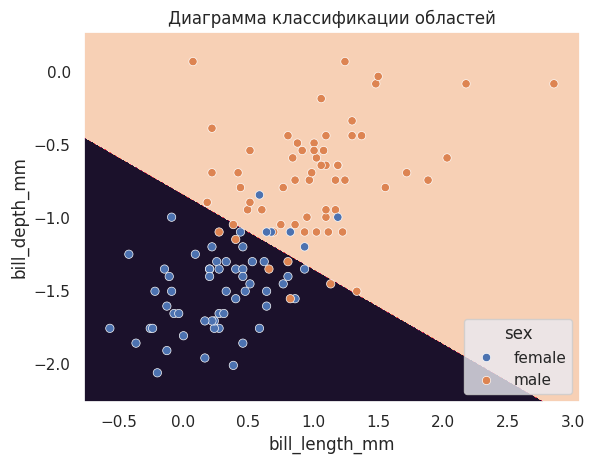

### Оценка качетсва:

Accuracy: 93.10%

# Chinstrap

### Кусочек обучающей выборки:

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
272,1.336195,0.525653,-0.283036,-0.567621,male
321,0.220750,-0.286845,-0.711125,-1.188572,female
320,1.500769,0.830340,-0.283036,-0.940192,male
285,-0.291258,0.068623,-1.424608,-0.753906,female
305,0.915617,1.185808,0.644491,-0.319240,male


### Параметры обучения:

,epoch,eta
,20,0.1


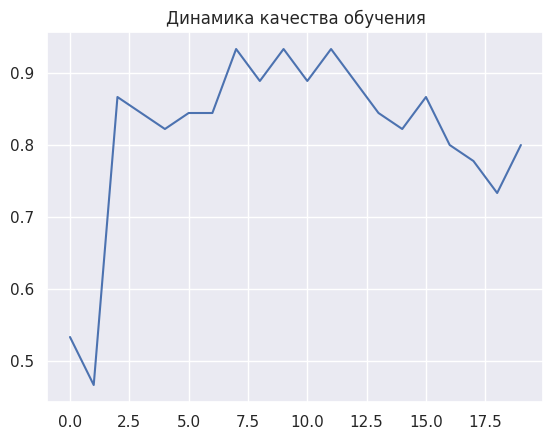

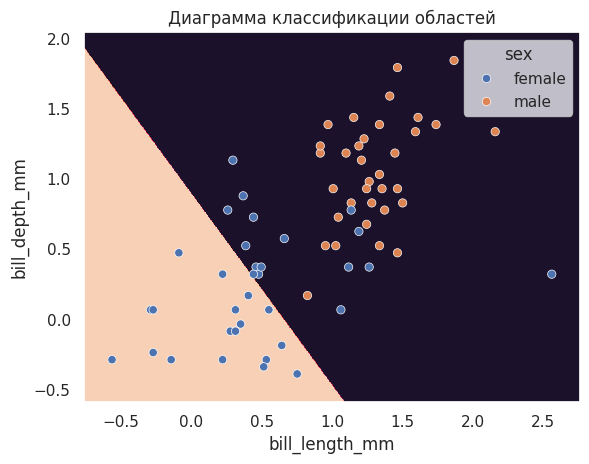

### Оценка качетсва:

Accuracy: 82.61%

In [12]:
models = dict()
for spec in df.species.unique():
    part = scaled[scaled.species==spec]
    part_train = part.index.intersection(train)
    display(Markdown(f"# {spec}"))
    models[spec] = model_report(
        model=Perceptron,
        dataset=part,
        X=numeric,
        y='sex',
        train=part_train,
        train_args=dict(
            epoch=20,
            eta=1e-1
        )
    )

### Сравнение моделей

,Adelie,Gentoo,Chinstrap,All
accuracy,0.854167,0.931034,0.826087,0.88


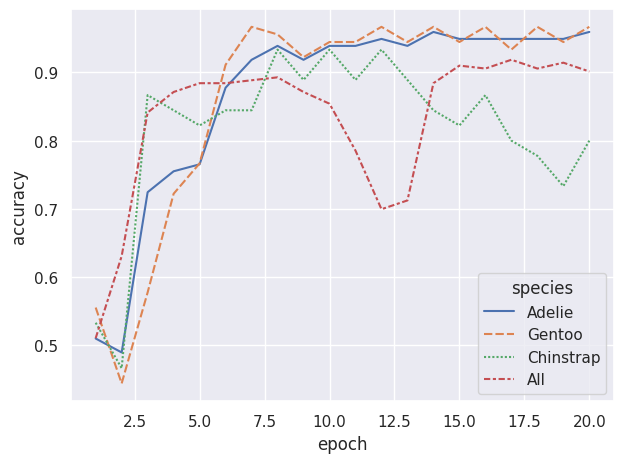

In [13]:
models["All"] = model_num
compare_models(
    models,
    dataset=scaled,
    X=numeric,
    y='sex',
    test=test,
)

На некоторых(Adelie) видах лучше получается разделять (лучше accuracy), т.к. признак 'sex' более линейно разделим.  

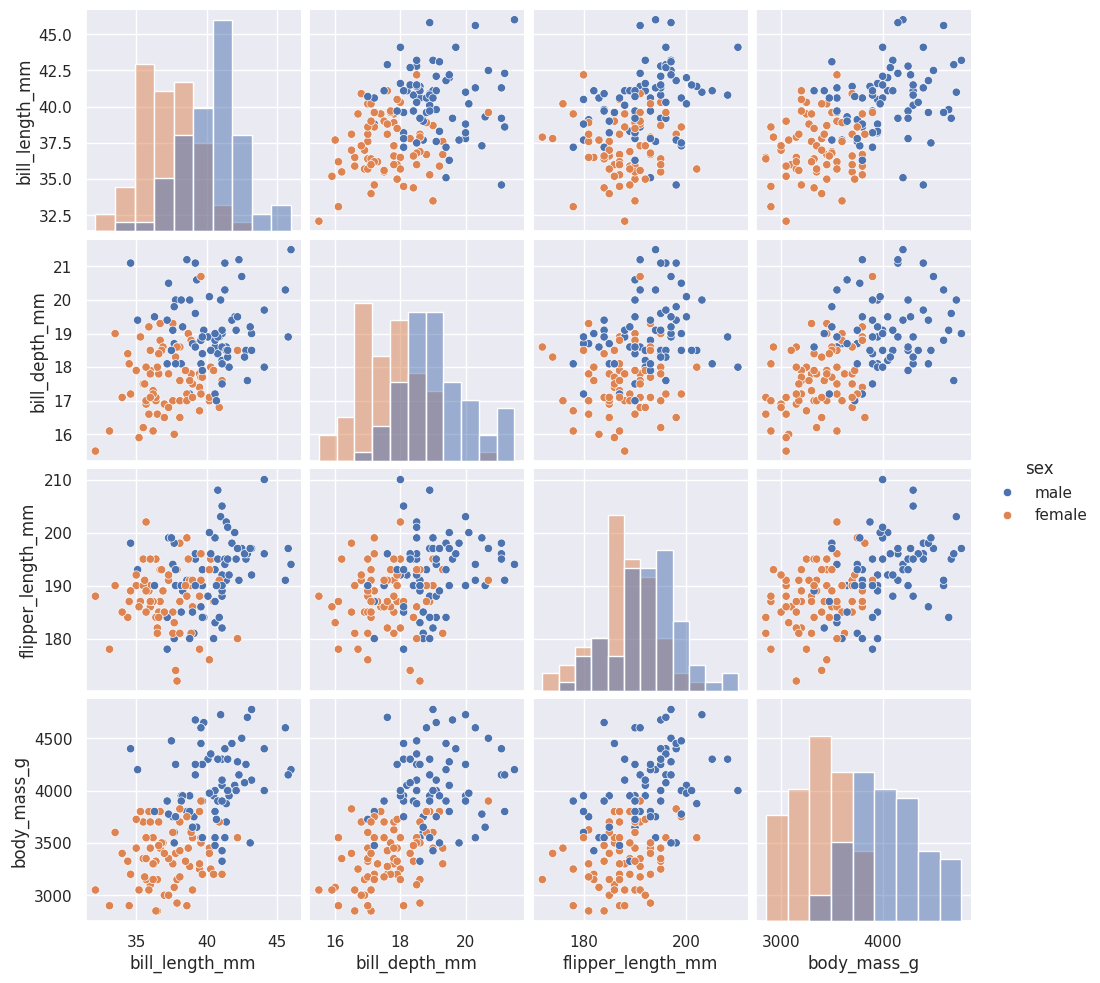

In [14]:
sns.pairplot(df[df['species'] == 'Adelie'], hue="sex", diag_kind="hist")
plt.show()

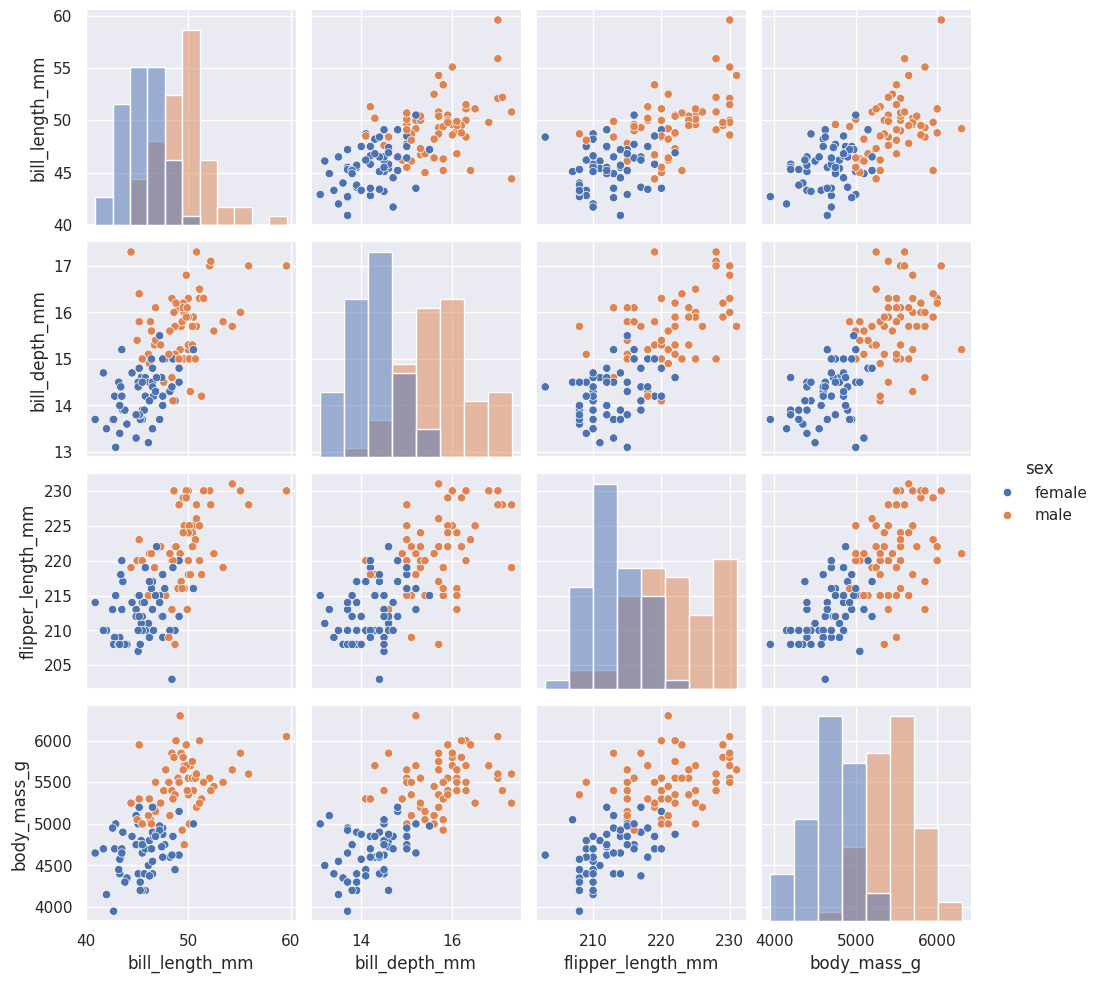

In [15]:
sns.pairplot(df[df['species'] == 'Gentoo'], hue="sex", diag_kind="hist")
plt.show()

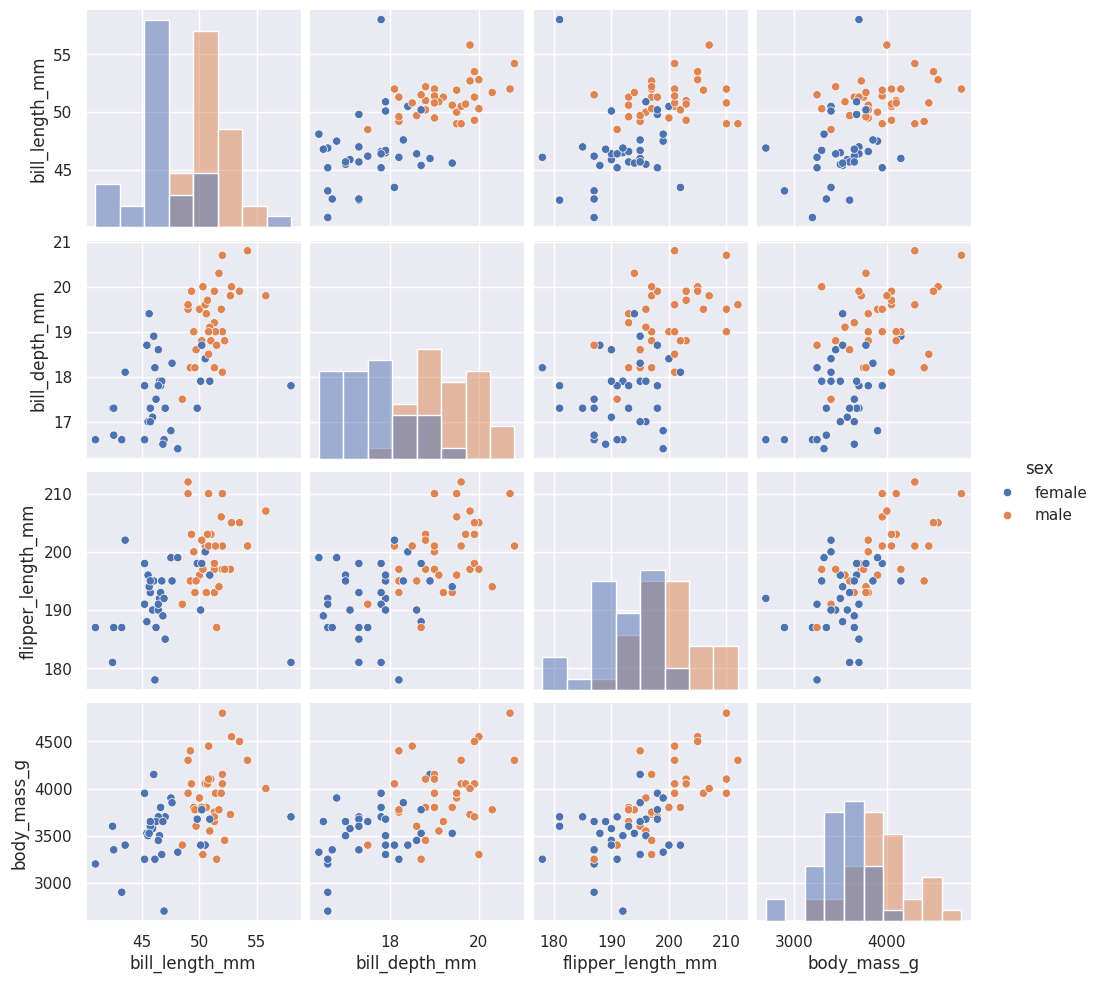

In [16]:
sns.pairplot(df[df['species'] == 'Chinstrap'], hue="sex", diag_kind="hist")
plt.show()

### 3. Попробуйте каждый из 3-х классификаторов п.2.2 проверить на всей выборке (т.е. на пингвинах разных видов).



In [17]:
for spec, model in models.items():
    model.print_accuracy(
        scaled.loc[test, numeric],
        scaled.loc[test, 'sex'],
        text=f'{spec} Accuracy'
    )

Adelie Accuracy: 76.00%
Gentoo Accuracy: 81.00%
Chinstrap Accuracy: 68.00%
All Accuracy: 88.00%


Получился результат на новых данных хуже,


# Задание 3. Бинарная классификация с использованием ADALINE.



Повторите пп.1-3 предыдущего задания, построив классификатор на основе адаптивного нейрона.


### 1. Используя персептрон, постройте бинарный классификатор для определения пола пингвина на основе только числовых признаков. Оцените качество работы классификатора.



### Кусочек обучающей выборки:

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,-0.894695,0.779559,-1.424608,-0.567621,male
11,-0.967839,0.931902,-0.425733,-0.940192,female
34,-0.766694,0.982683,-1.210563,0.550092,male
36,-0.583834,0.627216,-0.425733,-0.381335,male
50,-0.912981,0.170185,-1.067867,-0.816001,female


### Параметры обучения:

,eta,epoch
,0.001,40


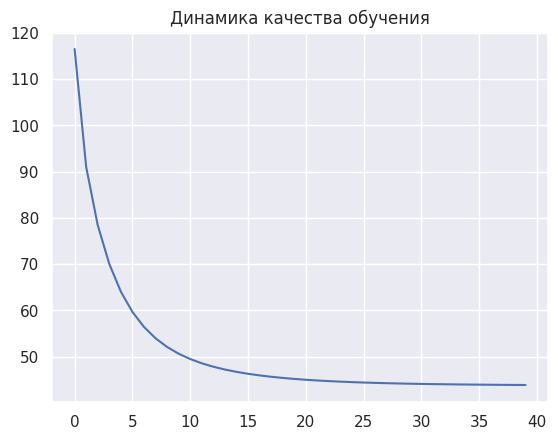

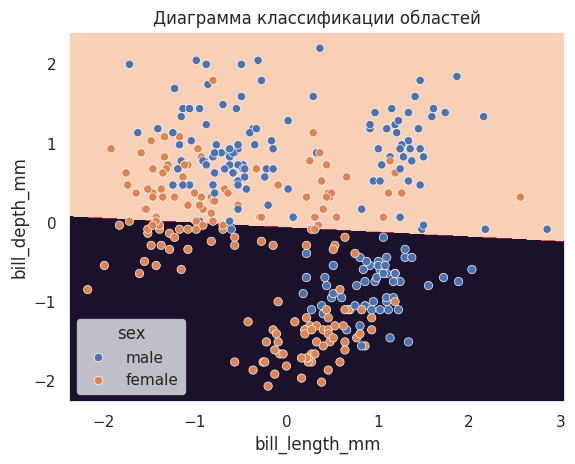

### Оценка качетсва:

Accuracy: 87.00%

In [18]:
model_num_ada = model_report(
    model=Perceptron_ada,
    dataset=scaled,
    X=numeric,
    y="sex",
    train=train,
    train_args=dict(
        eta=1e-3,
        epoch=40
    )
)

### 2. Постройте 3 классификатора для определения пола пингвина на основе числовых признаков для каждого из видов пингвинов. Оцените их качество. Сравните точности классификаторов между собой и с классификатором п.2.1.



# Adelie

### Кусочек обучающей выборки:

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
105,0.293894,1.592057,-0.711125,0.487997,male
47,-0.364402,1.185808,-0.068991,-0.195050,male
69,-0.218114,0.677997,-0.425733,0.053331,male
67,0.330466,0.881121,-0.283036,-0.070859,male
48,-1.735851,0.474872,-0.996518,-1.623238,female


### Параметры обучения:

,epoch,eta
,40,0.001


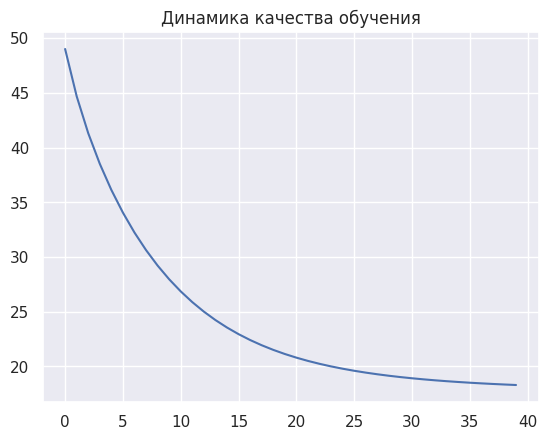

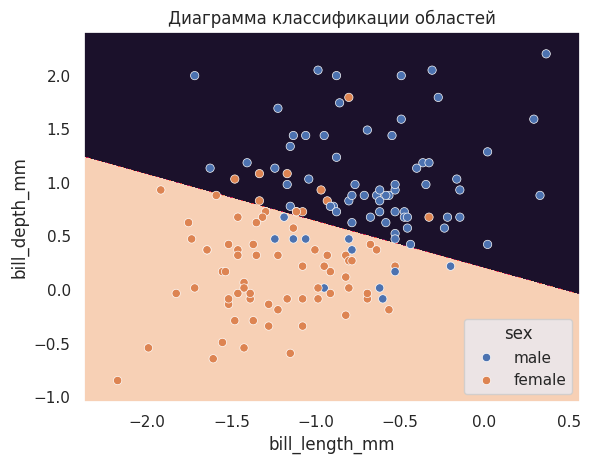

### Оценка качетсва:

Accuracy: 81.25%

# Gentoo

### Кусочек обучающей выборки:

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
243,1.299623,-0.337626,1.714714,1.295234,male
213,1.226479,-1.099343,1.572018,1.667805,male
247,0.933903,-1.099343,1.928759,1.605710,male
260,0.586470,-1.759497,0.929884,0.891616,female
175,0.604755,-0.946999,1.500670,1.295234,male


### Параметры обучения:

,epoch,eta
,40,0.001


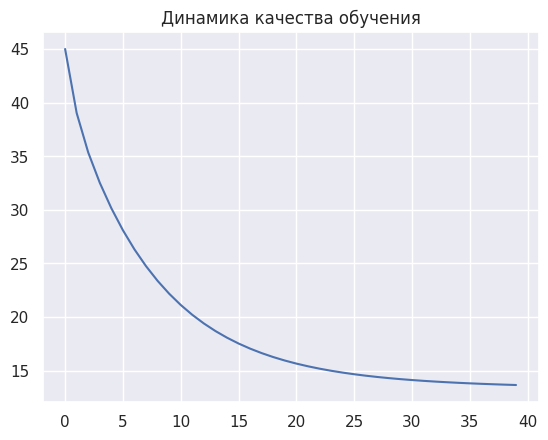

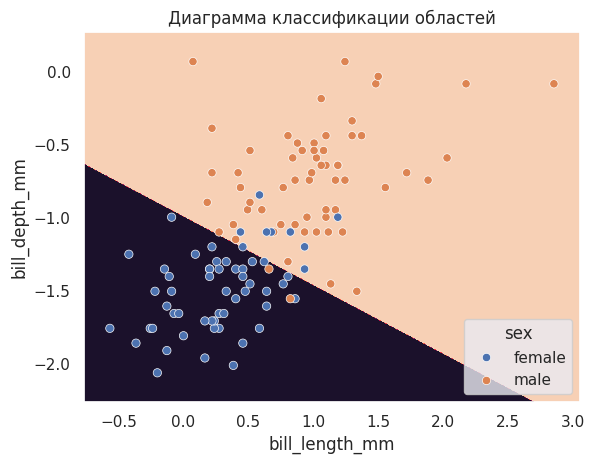

### Оценка качетсва:

Accuracy: 89.66%

# Chinstrap

### Кусочек обучающей выборки:

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
317,0.312180,0.068623,-0.568429,-0.753906,female
331,1.244765,0.931902,0.644491,-0.132954,male
324,0.293894,1.135027,-0.497081,-0.847049,female
290,1.464197,0.931902,-0.283036,-0.070859,male
328,2.159064,1.338151,0.430446,-0.257145,male


### Параметры обучения:

,epoch,eta
,40,0.001


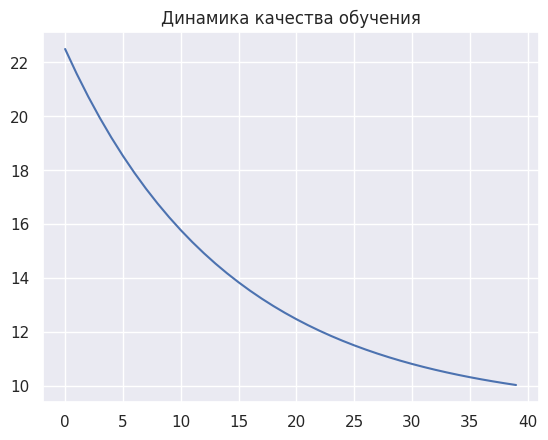

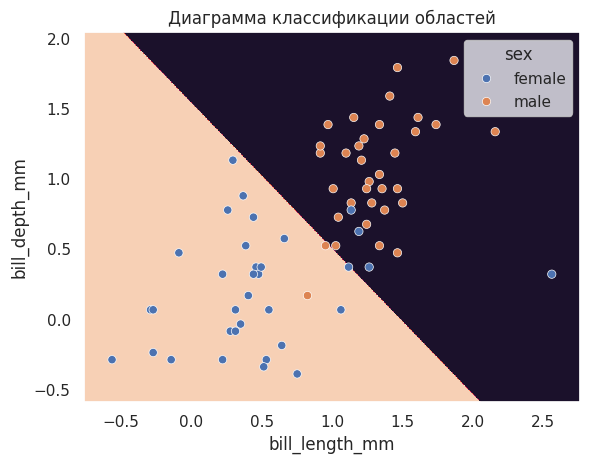

### Оценка качетсва:

Accuracy: 86.96%

In [19]:
models_ada = dict()
for spec in df.species.unique():
    part = scaled[scaled.species == spec]
    part_train = part.index.intersection(train)
    display(Markdown(f"# {spec}"))
    models_ada[spec] = model_report(
        model=Perceptron_ada,
        dataset=part,
        X=numeric,
        y='sex',
        train=part_train,
        train_args=dict(
            epoch=40,
            eta=1e-3
        )
    )

### Сравнение моделей

,Adelie,Gentoo,Chinstrap,All
accuracy,0.8125,0.896552,0.869565,0.87


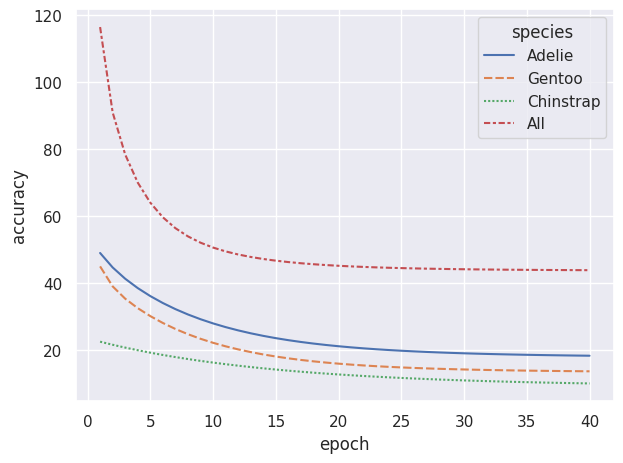

In [20]:
models_ada["All"] = model_num_ada
compare_models(
    models_ada,
    dataset=scaled,
    X=numeric,
    y='sex',
    test=test,
)

### 3. Попробуйте каждый из 3-х классификаторов п.2.2 проверить на всей выборке (т.е. на пингвинах разных видов).


In [21]:
for spec, model in models_ada.items():
    model.print_accuracy(scaled[numeric], df.sex, text=f'{spec} Accuracy')

Adelie Accuracy: 85.89%
Gentoo Accuracy: 84.08%
Chinstrap Accuracy: 72.07%
All Accuracy: 89.79%


### 4. Включите в список признаков вид пингвина, представив его числом (1,2,3) для разных видов. Оцените качество классификации и сравните с результатом пункта 3.1.


In [22]:
scaled['spec_num'] = np.select(
    condlist=[df.species == c
              for c in df.species.unique()],
    choicelist=(1, 2, 3)
)
scaled.sample(5)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,spec_num
212,Gentoo,Biscoe,-0.090112,-1.505592,1.357973,0.612187,female,2
191,Gentoo,Biscoe,0.275608,-1.657935,0.644491,-0.008764,female,2
270,Chinstrap,Dream,0.220750,0.322529,-0.211688,-0.319240,female,3
130,Adelie,Dream,-1.534705,0.170185,-0.711125,-1.281715,female,1
146,Gentoo,Biscoe,0.385324,-2.013403,0.715839,0.363807,female,2


### Кусочек обучающей выборки:

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,spec_num,sex
190,-0.071826,-1.657935,1.143928,0.860568,2,female
89,-0.583834,0.881121,0.501794,0.115426,1,male
107,-0.327830,1.185808,-0.283036,0.084379,1,male
231,1.336195,-1.505592,1.215277,1.357329,2,male
98,-1.114127,0.728778,-0.568429,-1.592191,1,female


### Параметры обучения:

,eta,epoch
,0.001,40


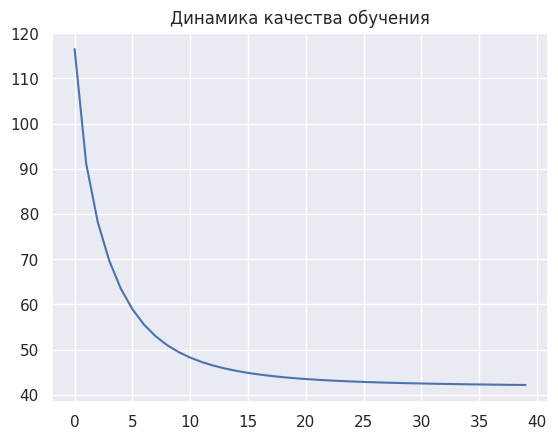

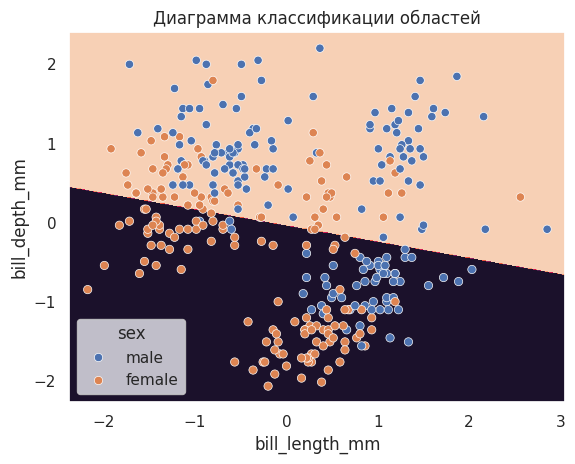

### Оценка качетсва:

Accuracy: 86.00%

In [23]:
_ = model_report(
    model=Perceptron_ada,
    dataset=scaled,
    X=numeric+['spec_num'],
    y='sex',
    train=train,
    train_args=dict(
        eta=1e-3,
        epoch=40,
    )
)

Качество не улучшилось

### 5. Замените признак вид на три бинарных признака Adelie, Chinstrap, Gentoo, в каждом из которых значение 1 соответствует тому, что данный пингвин принадлежит соответствующему виду: 

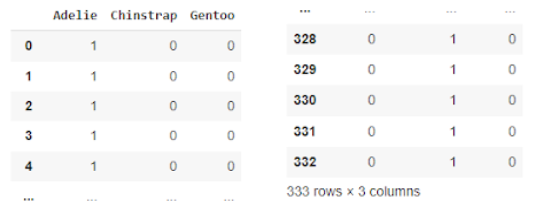

In [24]:
for spec in df.species.unique():
    scaled[spec] = (df.species == spec)*2-1
scaled.sample(5)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,spec_num,Adelie,Gentoo,Chinstrap
164,Gentoo,Biscoe,0.403610,-1.353248,0.573143,0.736378,female,2,-1,1,-1
8,Adelie,Torgersen,-0.986125,2.049087,-0.711125,-0.505525,male,1,1,-1,-1
169,Gentoo,Biscoe,0.421896,-0.693094,1.001232,1.046853,male,2,-1,1,-1
266,Chinstrap,Dream,1.098477,1.185808,-0.354384,-0.381335,male,3,-1,-1,1
34,Adelie,Dream,-0.766694,0.982683,-1.210563,0.550092,male,1,1,-1,-1


### Кусочек обучающей выборки:

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,Adelie,Gentoo,Chinstrap,sex
178,2.853932,-0.083720,2.071455,2.288757,-1,1,-1,male
96,-1.150699,-0.591532,-1.281911,-1.405905,1,-1,-1,female
214,0.677899,-1.099343,1.072580,0.674283,-1,1,-1,female
270,0.220750,0.322529,-0.211688,-0.319240,-1,-1,1,female
39,-1.278701,-0.134501,-1.139215,-1.499048,1,-1,-1,female


### Параметры обучения:

,eta,epoch
,0.001,40


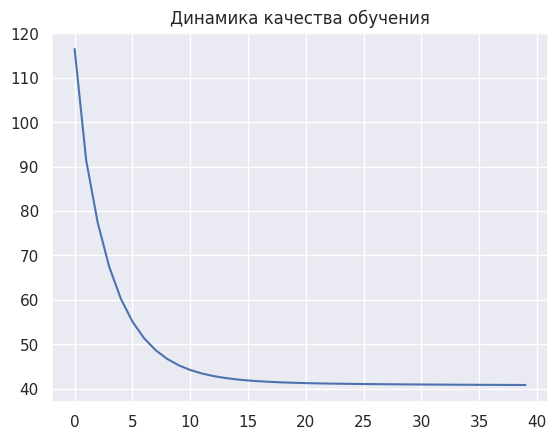

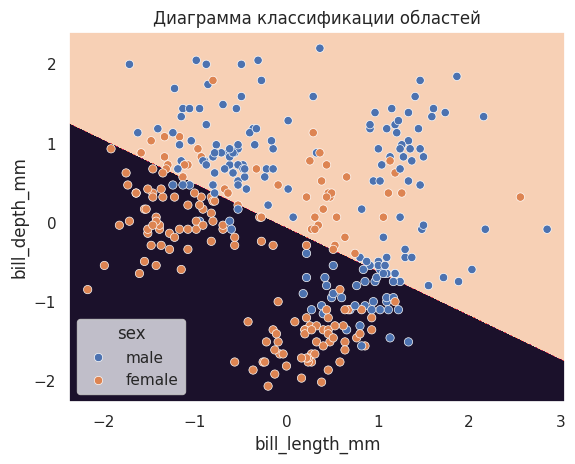

### Оценка качетсва:

Accuracy: 88.00%

In [25]:
numNspec = numeric+list(df.species.unique())
_ = model_report(
    model=Perceptron_ada,
    dataset=scaled,
    X=numNspec,
    y='sex',
    train=train,
    train_args=dict(
        eta=1e-3,
        epoch=40,
    )
)

Выполните классификацию по полу, используя уже 7 числовых признаков. Сравните качество классификации с предыдущими вариантами.


Качество немного улучшилось

### 6. Выполните классификацию по каждому из видов пингвина, используя 5 числовых признаков (4 размера-веса и пол: 1-male, 0-female). Сравните качество классификаторов.

In [26]:
scaled['sex_num'] = (df['sex'] == 'male')*2-1
scaled.sample(5)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,spec_num,Adelie,Gentoo,Chinstrap,sex_num
176,Gentoo,Biscoe,-0.218114,-1.505592,0.573143,0.612187,female,2,-1,1,-1,-1
132,Adelie,Dream,-1.278701,-0.337626,-1.139215,-1.002287,female,1,1,-1,-1,-1
251,Gentoo,Biscoe,-0.126684,-1.607154,0.501794,0.456949,female,2,-1,1,-1,-1
215,Gentoo,Biscoe,0.440182,-0.794656,1.429321,0.984758,male,2,-1,1,-1,1
25,Adelie,Dream,-0.821552,-0.236064,-1.638652,-1.188572,female,1,1,-1,-1,-1


# Adelie

### Кусочек обучающей выборки:

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex_num,Adelie
218,0.440182,-1.099343,1.072580,0.612187,-1,-1
173,0.769329,-1.454811,0.644491,0.487997,-1,-1
321,0.220750,-0.286845,-0.711125,-1.188572,-1,-1
125,-0.163256,1.033465,-0.283036,-0.878096,1,1
106,-0.784980,0.271748,-0.568429,-1.250667,-1,1


### Параметры обучения:

,eta,random_state
,0.001,42


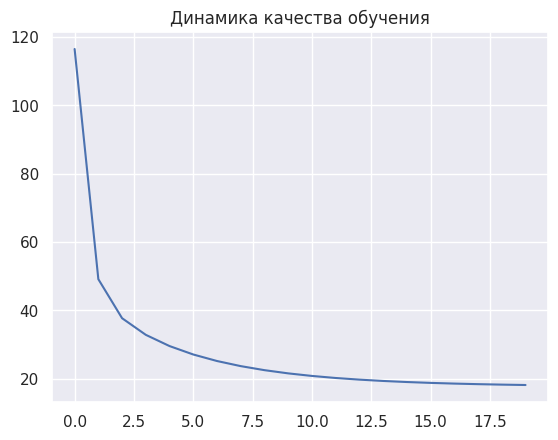

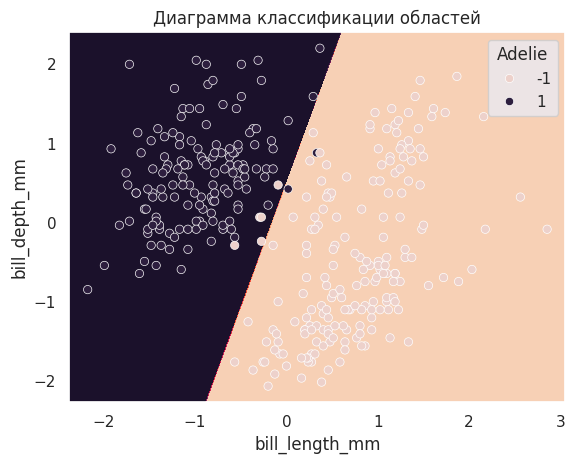

### Оценка качетсва:

Accuracy: 98.00%

# Gentoo

### Кусочек обучающей выборки:

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex_num,Gentoo
272,1.336195,0.525653,-0.283036,-0.567621,1,-1
241,0.531612,-1.302467,1.500670,0.829520,-1,1
252,0.751043,-1.048562,0.573143,1.605710,1,1
329,-0.090112,0.474872,0.073705,-1.002287,-1,-1
105,0.293894,1.592057,-0.711125,0.487997,1,-1


### Параметры обучения:

,eta,random_state
,0.001,42


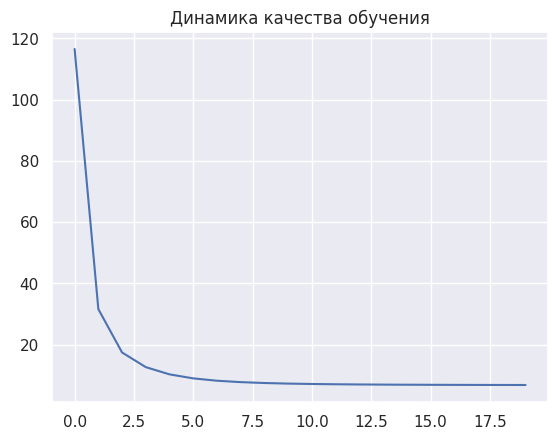

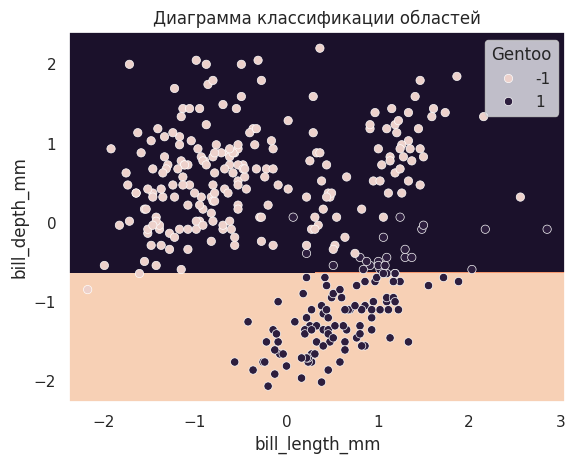

### Оценка качетсва:

Accuracy: 100.00%

# Chinstrap

### Кусочек обучающей выборки:

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex_num,Chinstrap
89,-0.583834,0.881121,0.501794,0.115426,1,-1
43,-0.309544,2.049087,-0.711125,-0.070859,1,-1
267,1.336195,1.033465,-0.568429,-0.691811,1,1
270,0.220750,0.322529,-0.211688,-0.319240,-1,1
92,-1.991855,-0.540750,-1.638652,-1.623238,-1,-1


### Параметры обучения:

,eta,random_state
,0.001,42


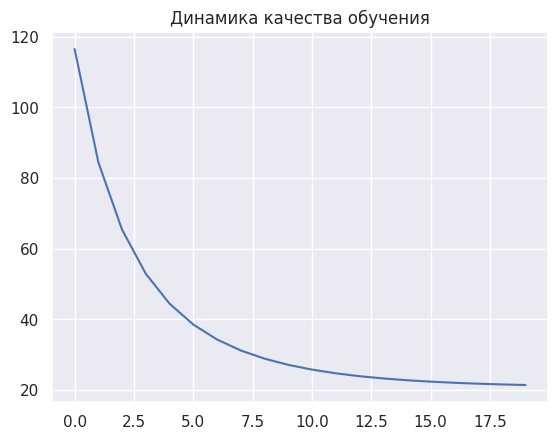

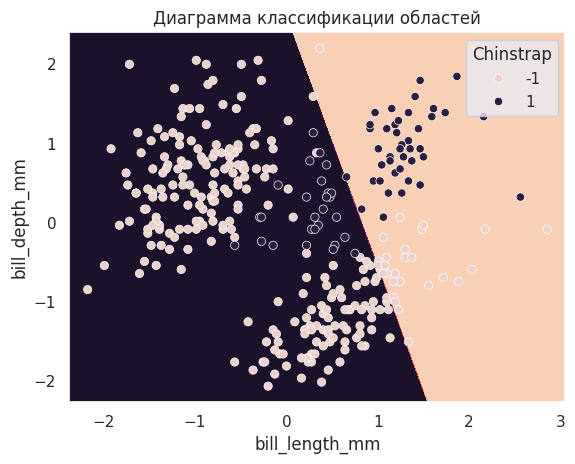

### Оценка качетсва:

Accuracy: 97.00%

Adelie Test Accyracy: 98.00%
Gentoo Test Accyracy: 100.00%
Chinstrap Test Accyracy: 97.00%


In [27]:
numNsex = list(numeric)+["sex_num"]

models = dict()
for spec in df.species.unique():
    display(Markdown(f"# {spec}"))
    models[spec] = model_report(
        model=Perceptron_ada,
        dataset=scaled,
        X=numNsex,
        y=spec,
        train=train,
        train_args=dict(
            eta=1e-3,
            random_state=42,
        )
    )


for spec, model in models.items():
    model.print_accuracy(
        scaled.loc[test, numNsex],
        scaled.loc[test, spec],
        f"{spec} Test Accyracy"
    )

### 7. Повторите предыдущий пункт, добавив к 5 числовым признакам ещё три бинарных, представляющих принадлежность к тому или иному острову.


In [28]:
for island in df.island.unique():
    scaled[island] = (df.island == island)*2-1
scaled.sample(5)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,spec_num,Adelie,Gentoo,Chinstrap,sex_num,Torgersen,Biscoe,Dream
306,Chinstrap,Dream,0.403610,0.170185,-0.996518,-0.691811,female,3,-1,-1,1,-1,-1,-1,1
159,Gentoo,Biscoe,0.805901,-1.302467,0.858536,2.040376,male,2,-1,1,-1,1,-1,1,-1
130,Adelie,Dream,-1.534705,0.170185,-0.711125,-1.281715,female,1,1,-1,-1,-1,-1,-1,1
297,Chinstrap,Dream,-0.272972,-0.236064,-0.996518,-1.064382,female,3,-1,-1,1,-1,-1,-1,1
200,Gentoo,Biscoe,0.184178,-0.896218,1.357973,1.046853,male,2,-1,1,-1,1,-1,1,-1


# Adelie

### Кусочек обучающей выборки:

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex_num,Torgersen,Biscoe,Dream,Adelie
305,0.915617,1.185808,0.644491,-0.319240,1,-1,-1,1,-1
27,-0.821552,0.322529,-0.925170,-1.126477,-1,-1,-1,1,1
193,0.165892,-1.962622,0.858536,1.108949,-1,-1,1,-1,-1
144,-1.461561,-0.032939,-0.996518,-0.629716,-1,-1,-1,1,1
245,2.177350,-0.083720,1.928759,1.729900,1,-1,1,-1,-1


### Параметры обучения:

,eta,random_state
,0.001,42


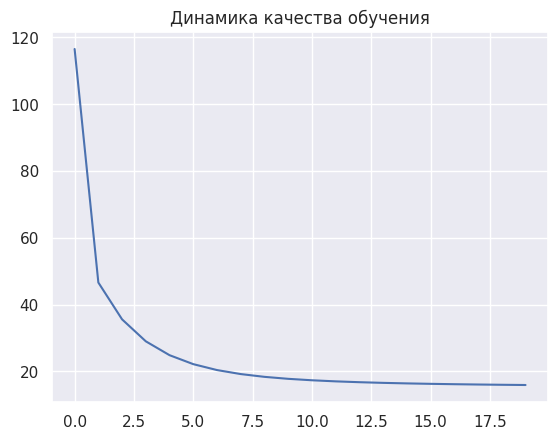

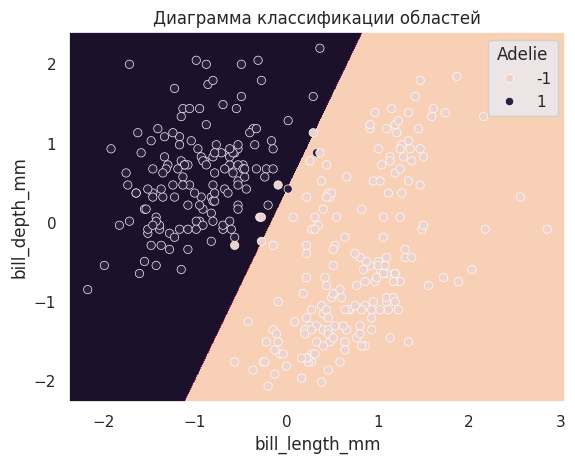

### Оценка качетсва:

Accuracy: 100.00%

# Gentoo

### Кусочек обучающей выборки:

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex_num,Torgersen,Biscoe,Dream,Gentoo
196,0.824187,-1.556373,1.357973,1.357329,1,-1,1,-1,1
87,-0.803266,0.474872,-1.067867,0.301712,1,-1,-1,1,-1
200,0.184178,-0.896218,1.357973,1.046853,1,-1,1,-1,1
8,-0.986125,2.049087,-0.711125,-0.505525,1,1,-1,-1,-1
279,0.348752,-0.032939,-0.782474,-0.784954,-1,-1,-1,1,-1


### Параметры обучения:

,eta,random_state
,0.001,42


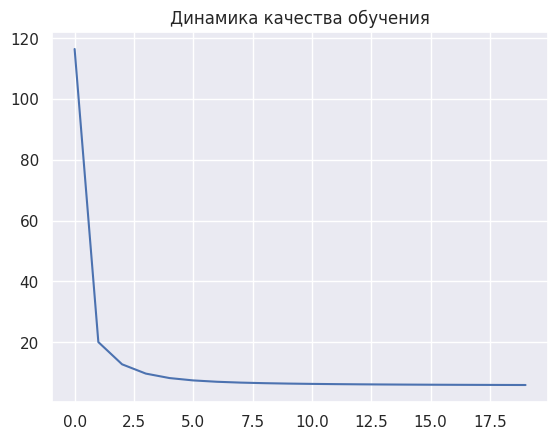

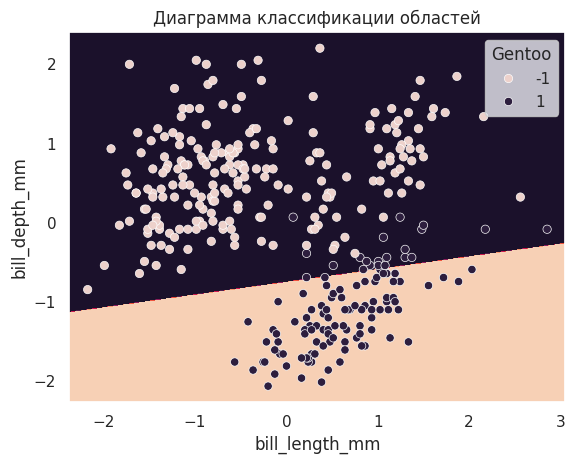

### Оценка качетсва:

Accuracy: 100.00%

# Chinstrap

### Кусочек обучающей выборки:

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex_num,Torgersen,Biscoe,Dream,Chinstrap
218,0.440182,-1.099343,1.072580,0.612187,-1,-1,1,-1,-1
205,0.239036,-1.708716,0.501794,-0.008764,-1,-1,1,-1,-1
233,1.482483,-0.083720,2.071455,1.667805,1,-1,1,-1,-1
56,-1.168985,-0.083720,-1.139215,-0.753906,-1,-1,1,-1,-1
217,0.458468,-1.200905,1.143928,1.233139,-1,-1,1,-1,-1


### Параметры обучения:

,eta,random_state
,0.001,42


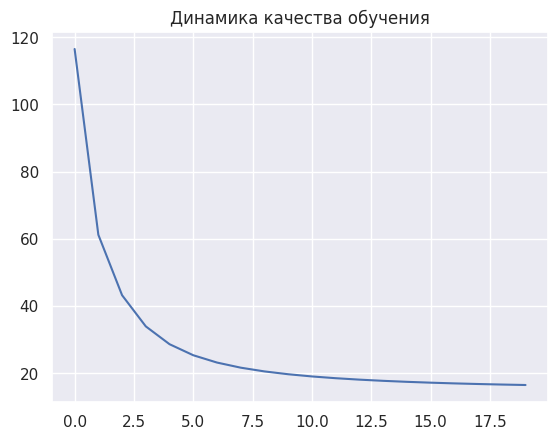

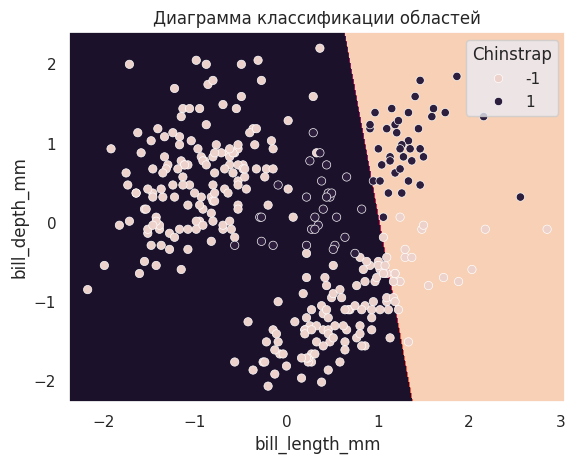

### Оценка качетсва:

Accuracy: 99.00%

Adelie Test Accyracy: 100.00%
Gentoo Test Accyracy: 100.00%
Chinstrap Test Accyracy: 99.00%


In [29]:
numNsexNisland = numNsex + list(df.island.unique())

models = dict()
for spec in df.species.unique():
    display(Markdown(f"# {spec}"))
    models[spec] = model_report(
        model=Perceptron_ada,
        dataset=scaled,
        X=numNsexNisland,
        y=spec,
        train=train,
        train_args=dict(
            eta=1e-3,
            random_state=42,
        )
    )


for spec, model in models.items():
    model.print_accuracy(
        scaled.loc[test, numNsexNisland],
        scaled.loc[test, spec],
        f"{spec} Test Accyracy"
    )

# Задание 4. Множественная классификация с использованием ADALINE.

Постройте сеть из 4 нейронов. На первом слое три из них определяют принадлежность к одному из трёх видов пингвинов. На втором слое на основе оценок 1-го слоя выносится суждение о том, какому из видов принадлежит конкретный объект. Нейрон этого слоя тоже надо обучить.
Провести расчёты в трёх вариантах: используя 4 числовых слоя (только размеры-веса), используя 5 числовых слоёв (+пол), используя 8 числовых слоёв (+остров).
Оценить качество полученных классификаторов. Сделать вывод.



## 1. Используя 4 числовых слоя

### Кусочек обучающей выборки:

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,species
50,-0.912981,0.170185,-1.067867,-0.816001,Adelie
287,-0.144970,-0.286845,-0.996518,-1.623238,Chinstrap
34,-0.766694,0.982683,-1.210563,0.550092,Adelie
134,-0.693550,-0.032939,-0.568429,-1.002287,Adelie
284,0.952189,0.525653,-0.425733,0.239616,Chinstrap


### Параметры обучения:

,epoch,eta
,40,0.001


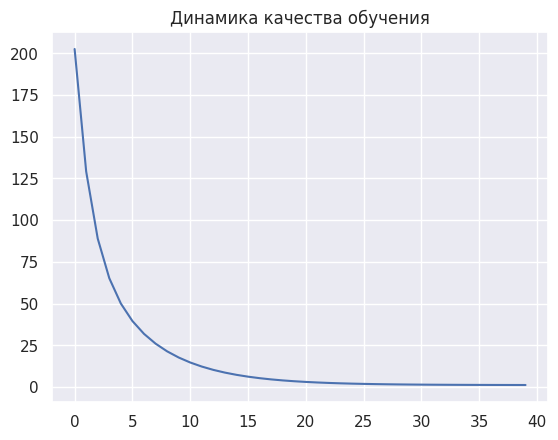

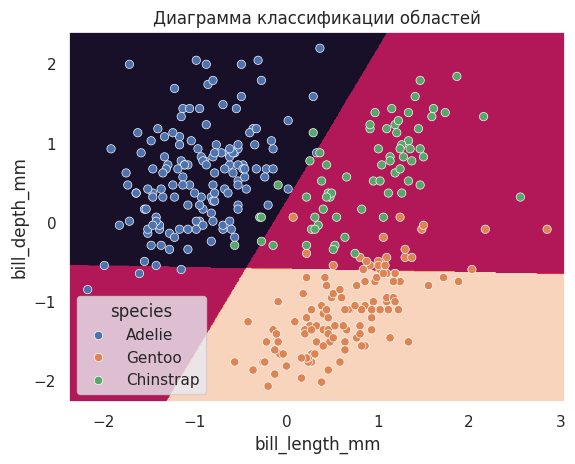

### Оценка качетсва:

Accuracy: 98.00%

In [30]:
_ = model_report(
    model=Perceptron_multi,
    dataset=scaled,
    X=numeric,
    y="species",
    train=train,
    train_args=dict(
        epoch=40,
        eta=1e-3,
    )
)

Оценка за работу 5 баллов.
Дополнительные 2 балла могут быть выставлены, если обучение каждого классификатора сопровождается выводом графика динамики качества обучения по эпохам и диаграммы классификации областей (оси – два числовых признака размер/вес на выбор студента).


Дополнительный 1 балл за вывод перед каждым обучением информации о характере обучения и первых 5-ти строк обучающей выборки.


## 2. Используя 5 числовых слоёв

### Кусочек обучающей выборки:

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex_num,species
91,-0.675264,0.677997,-0.354384,0.177521,1,Adelie
156,-0.565548,-1.759497,0.929884,0.550092,-1,Gentoo
71,-1.242129,1.135027,-1.210563,-0.381335,1,Adelie
254,1.061905,-0.642313,2.000107,2.164566,1,Gentoo
121,-0.455832,0.576434,-0.425733,0.115426,1,Adelie


### Параметры обучения:

,eta,epoch
,0.001,40


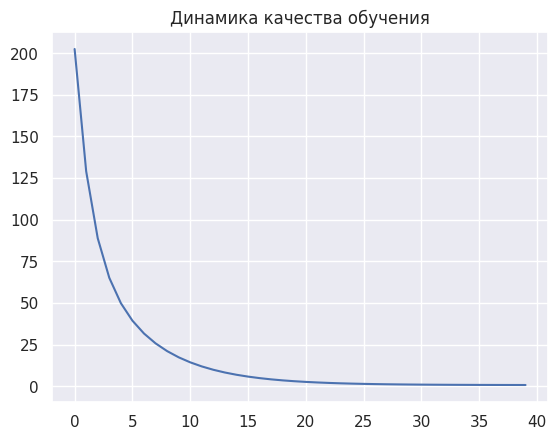

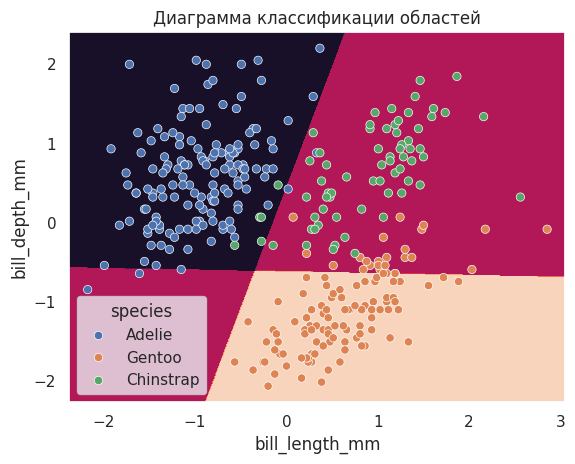

### Оценка качетсва:

Accuracy: 99.00%

In [31]:
_ = model_report(
    model=Perceptron_multi,
    dataset=scaled,
    X=numNsex,
    y='species',
    train=train,
    train_args=dict(
        eta=1e-3,
        epoch=40,
    ),
)

## 3. Используя 8 числовых слоёв

### Кусочек обучающей выборки:

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex_num,Torgersen,Biscoe,Dream,species
227,1.098477,-0.642313,1.643366,1.419424,1,-1,1,-1,Gentoo
202,0.275608,-1.099343,1.357973,0.984758,1,-1,1,-1,Gentoo
271,0.385324,0.525653,-1.638652,-1.188572,-1,-1,-1,1,Chinstrap
298,1.281337,0.830340,0.145053,-0.132954,1,-1,-1,1,Chinstrap
134,-0.693550,-0.032939,-0.568429,-1.002287,-1,-1,-1,1,Adelie


### Параметры обучения:

,eta,epoch
,0.001,40


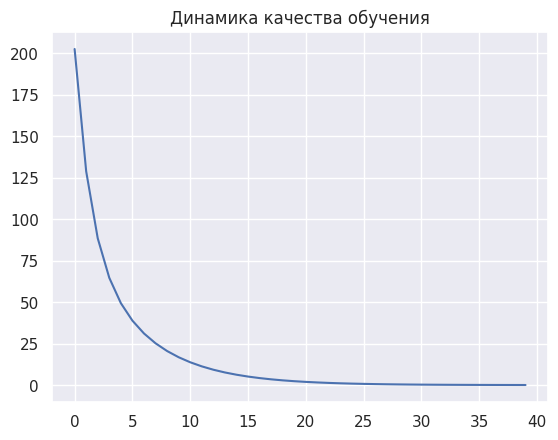

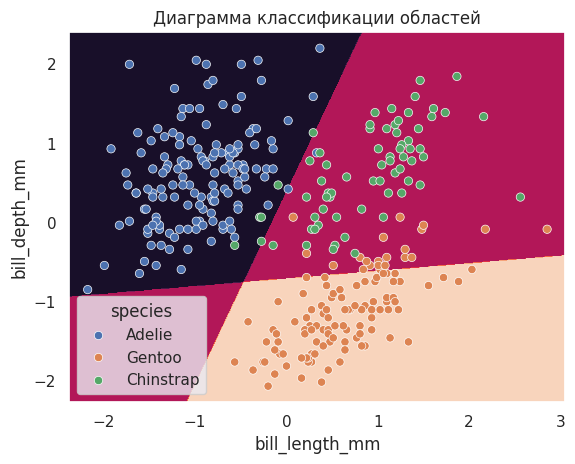

### Оценка качетсва:

Accuracy: 100.00%

In [32]:
numNsexNisland = numNsex + list(df.island.unique())

_ = model_report(
    model=Perceptron_multi,
    dataset=scaled,
    X=numNsexNisland,
    y='species',
    train=train,
    train_args=dict(
        eta=1e-3,
        epoch=40,
    ),
)

Вывод, чем больше информации, тем лучше